# Machine Learning: Supervised Classification

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (confusion_matrix, precision_score,accuracy_score,
                            recall_score,mean_squared_error,roc_curve, auc)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

We Use the Cumulative Database of Objects of Interest of the Kepler Exoplanet Observatory at https://exoplanetarchive.ipac.caltech.edu/docs/data.html

In this notebook we use several classifiers in order to reproduce de disposition of the observed object among the classes CONFIRMED and FALSE POSITIVE.

In [37]:
# Load the exoplanet database from kepler
#data_url = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=cumulative&select=koi_disposition,ra,dec,koi_period,koi_duration,koi_depth,koi_prad,koi_insol,koi_teq,koi_steff,koi_slogg,koi_srad&format=csv"

#URLs
url_koi = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=cumulative&select=koi_disposition,ra,dec,koi_period,koi_duration,koi_depth,koi_prad,koi_insol,koi_teq,koi_steff,koi_slogg,koi_srad&format=csv"
url_toi = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=toi&select=tfopwg_disp,ra,dec,pl_orbper,pl_trandurh,pl_trandep,pl_rade,pl_insol,pl_eqt,st_teff,st_logg,st_rad&format=csv"
url_k2  = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+disposition,ra,dec,pl_orbper,pl_trandur,(pl_trandep*10000),pl_rade,pl_insol,pl_eqt,st_teff,st_logg,st_rad+from+k2pandc+order+by+hostname+asc,pl_letter+asc,pl_name+asc&format=csv"

# Read the tables
#df_kepler = pd.read_csv(data_url)

# Leer
df_koi = pd.read_csv(url_koi, low_memory=False)
df_toi = pd.read_csv(url_toi, low_memory=False)
df_k2  = pd.read_csv(url_k2,  low_memory=False)

#df_kepler

# Renombrar columnas para estandarizar
df_koi_renamed = df_koi.rename(columns={
    'koi_disposition': 'disposition',
    'koi_period': 'period',
    'koi_duration': 'duration',
    'koi_depth': 'depth',
    'koi_prad': 'planet_radius',
    'koi_insol': 'insolation',
    'koi_teq': 'equilibrium_temp',
    'koi_steff': 'stellar_teff',
    'koi_slogg': 'stellar_logg',
    'koi_srad': 'stellar_radius'
})

df_toi_renamed = df_toi.rename(columns={
    'tfopwg_disp': 'disposition',
    'pl_orbper': 'period',
    'pl_trandurh': 'duration',
    'pl_trandep': 'depth',
    'pl_rade': 'planet_radius',
    'pl_insol': 'insolation',
    'pl_eqt': 'equilibrium_temp',
    'st_teff': 'stellar_teff',
    'st_logg': 'stellar_logg',
    'st_rad': 'stellar_radius'
})

df_k2_renamed = df_k2.rename(columns={
    'pl_orbper': 'period',
    'pl_trandur': 'duration',
    '(pl_trandep*10000)': 'depth',  # Nombre corregido
    'pl_rade': 'planet_radius',
    'pl_insol': 'insolation',
    'pl_eqt': 'equilibrium_temp',
    'st_teff': 'stellar_teff',
    'st_logg': 'stellar_logg',
    'st_rad': 'stellar_radius'
})

# Agregar columna de origen para identificar cada dataset
#df_koi_renamed['source'] = 'KOI'
#df_toi_renamed['source'] = 'TOI'
#df_k2_renamed['source'] = 'K2'

# Unir todos los DataFrames
df_combined = pd.concat([df_koi_renamed, df_toi_renamed, df_k2_renamed], 
                       ignore_index=True, sort=False)

print(f"Dataset combinado: {len(df_combined)} filas")
print(f"Columnas: {df_combined.columns.tolist()}")

df_combined

Dataset combinado: 21271 filas
Columnas: ['disposition', 'ra', 'dec', 'period', 'duration', 'depth', 'planet_radius', 'insolation', 'equilibrium_temp', 'stellar_teff', 'stellar_logg', 'stellar_radius']


,disposition,ra,dec,period,duration,depth,planet_radius,insolation,equilibrium_temp,stellar_teff,stellar_logg,stellar_radius
0,CONFIRMED,291.934230,48.141651,9.488036,2.957500,615.800000,2.26000,93.5900,793.00,5455.00,4.46700,0.927000
1,CONFIRMED,291.934230,48.141651,54.418383,4.507000,874.800000,2.83000,9.1100,443.00,5455.00,4.46700,0.927000
2,CANDIDATE,297.004820,48.134129,19.899140,1.782200,10829.000000,14.60000,39.3000,638.00,5853.00,4.54400,0.868000
3,FALSE POSITIVE,285.534610,48.285210,1.736952,2.406410,8079.200000,33.46000,891.9600,1395.00,5805.00,4.56400,0.791000
4,CONFIRMED,288.754880,48.226200,2.525592,1.654500,603.300000,2.75000,926.1600,1406.00,6031.00,4.43800,1.046000
...,...,...,...,...,...,...,...,...,...,...,...,...
21266,CONFIRMED,175.908033,6.563784,2.656627,3.025000,14590.000000,NaN,NaN,NaN,5634.18,NaN,NaN
21267,CONFIRMED,206.846198,-6.139337,NaN,1.647926,744.359478,1.75752,12.6807,481.29,4759.00,4.70975,0.641805
21268,CONFIRMED,206.846198,-6.139337,6.001270,NaN,NaN,2.04300,64.7000,789.00,4716.00,NaN,0.689000
21269,CONFIRMED,206.846198,-6.139337,6.001270,1.330000,NaN,2.04300,NaN,790.00,4716.00,4.62000,0.689000


Drop All NaNs

In [38]:
#df_kepler_clean=df_kepler.dropna().reset_index(drop=True)
df_kepler_clean=df_combined.dropna().reset_index(drop=True)
df_kepler_clean

,disposition,ra,dec,period,duration,depth,planet_radius,insolation,equilibrium_temp,stellar_teff,stellar_logg,stellar_radius
0,CONFIRMED,291.934230,48.141651,9.488036,2.957500,615.800000,2.260000,93.5900,793.00,5455.0,4.4670,0.92700
1,CONFIRMED,291.934230,48.141651,54.418383,4.507000,874.800000,2.830000,9.1100,443.00,5455.0,4.4670,0.92700
2,CANDIDATE,297.004820,48.134129,19.899140,1.782200,10829.000000,14.600000,39.3000,638.00,5853.0,4.5440,0.86800
3,FALSE POSITIVE,285.534610,48.285210,1.736952,2.406410,8079.200000,33.460000,891.9600,1395.00,5805.0,4.5640,0.79100
4,CONFIRMED,288.754880,48.226200,2.525592,1.654500,603.300000,2.750000,926.1600,1406.00,6031.0,4.4380,1.04600
...,...,...,...,...,...,...,...,...,...,...,...,...
16001,CONFIRMED,349.063465,0.306690,4.533470,3.605251,11929.861969,13.221703,501.4021,1206.89,5846.0,4.3100,1.19710
16002,CONFIRMED,353.616269,-1.579985,3.408833,3.163000,16032.000000,14.263200,695.6500,1430.00,6134.0,4.4100,1.11000
16003,CONFIRMED,331.203092,-12.019067,4.159149,3.540000,12800.000000,12.161600,417.2950,1259.00,5576.0,4.3400,1.11000
16004,CONFIRMED,203.758195,-17.503496,4.465634,3.512518,17333.755723,14.646776,471.6016,1188.54,6070.0,4.4201,1.09036


We keep only physical data of the observed object

In [39]:
df=df_kepler_clean  #.drop(['kepid', 'kepoi_name'], axis=1)

We take only information about the classes CONFIRMED and FALSE POSITIVE for the binary classification in order to obtain a model that can be used on the CANDIDATE class.

In [41]:
# Crear un mapeo para cambiar las etiquetas específicas
disposition_mapping = {
    'APC': 'CANDIDATE',
    'CP': 'CONFIRMED', 
    'FA': 'FALSE POSITIVE',
    'FP': 'FALSE POSITIVE',
    'KP': 'CONFIRMED',
    'PC': 'CANDIDATE',
    'REFUTED': 'FALSE POSITIVE'
}

# Aplicar los cambios usando replace
df['disposition'] = df['disposition'].replace(disposition_mapping)

# Verificar los resultados
print("Valores únicos después del cambio:")
print(df['disposition'].unique())
df

Valores únicos después del cambio:
['CONFIRMED' 'CANDIDATE' 'FALSE POSITIVE']


,disposition,ra,dec,period,duration,depth,planet_radius,insolation,equilibrium_temp,stellar_teff,stellar_logg,stellar_radius
0,CONFIRMED,291.934230,48.141651,9.488036,2.957500,615.800000,2.260000,93.5900,793.00,5455.0,4.4670,0.92700
1,CONFIRMED,291.934230,48.141651,54.418383,4.507000,874.800000,2.830000,9.1100,443.00,5455.0,4.4670,0.92700
2,CANDIDATE,297.004820,48.134129,19.899140,1.782200,10829.000000,14.600000,39.3000,638.00,5853.0,4.5440,0.86800
3,FALSE POSITIVE,285.534610,48.285210,1.736952,2.406410,8079.200000,33.460000,891.9600,1395.00,5805.0,4.5640,0.79100
4,CONFIRMED,288.754880,48.226200,2.525592,1.654500,603.300000,2.750000,926.1600,1406.00,6031.0,4.4380,1.04600
...,...,...,...,...,...,...,...,...,...,...,...,...
16001,CONFIRMED,349.063465,0.306690,4.533470,3.605251,11929.861969,13.221703,501.4021,1206.89,5846.0,4.3100,1.19710
16002,CONFIRMED,353.616269,-1.579985,3.408833,3.163000,16032.000000,14.263200,695.6500,1430.00,6134.0,4.4100,1.11000
16003,CONFIRMED,331.203092,-12.019067,4.159149,3.540000,12800.000000,12.161600,417.2950,1259.00,5576.0,4.3400,1.11000
16004,CONFIRMED,203.758195,-17.503496,4.465634,3.512518,17333.755723,14.646776,471.6016,1188.54,6070.0,4.4201,1.09036


In [42]:
df=df[df['disposition']!='CANDIDATE'].reset_index(drop=True)
df

,disposition,ra,dec,period,duration,depth,planet_radius,insolation,equilibrium_temp,stellar_teff,stellar_logg,stellar_radius
0,CONFIRMED,291.934230,48.141651,9.488036,2.957500,615.800000,2.260000,93.5900,793.00,5455.0,4.4670,0.92700
1,CONFIRMED,291.934230,48.141651,54.418383,4.507000,874.800000,2.830000,9.1100,443.00,5455.0,4.4670,0.92700
2,FALSE POSITIVE,285.534610,48.285210,1.736952,2.406410,8079.200000,33.460000,891.9600,1395.00,5805.0,4.5640,0.79100
3,CONFIRMED,288.754880,48.226200,2.525592,1.654500,603.300000,2.750000,926.1600,1406.00,6031.0,4.4380,1.04600
4,CONFIRMED,296.286130,48.224670,11.094321,4.594500,1517.500000,3.900000,114.8100,835.00,6046.0,4.4860,0.97200
...,...,...,...,...,...,...,...,...,...,...,...,...
9700,CONFIRMED,349.063465,0.306690,4.533470,3.605251,11929.861969,13.221703,501.4021,1206.89,5846.0,4.3100,1.19710
9701,CONFIRMED,353.616269,-1.579985,3.408833,3.163000,16032.000000,14.263200,695.6500,1430.00,6134.0,4.4100,1.11000
9702,CONFIRMED,331.203092,-12.019067,4.159149,3.540000,12800.000000,12.161600,417.2950,1259.00,5576.0,4.3400,1.11000
9703,CONFIRMED,203.758195,-17.503496,4.465634,3.512518,17333.755723,14.646776,471.6016,1188.54,6070.0,4.4201,1.09036


In [44]:
df['disposition'].unique()

array(['CONFIRMED', 'FALSE POSITIVE'], dtype=object)

Encode the target variable

In [45]:
le=LabelEncoder()
df['disposition']=le.fit_transform(df['disposition'])
df

,disposition,ra,dec,period,duration,depth,planet_radius,insolation,equilibrium_temp,stellar_teff,stellar_logg,stellar_radius
0,0,291.934230,48.141651,9.488036,2.957500,615.800000,2.260000,93.5900,793.00,5455.0,4.4670,0.92700
1,0,291.934230,48.141651,54.418383,4.507000,874.800000,2.830000,9.1100,443.00,5455.0,4.4670,0.92700
2,1,285.534610,48.285210,1.736952,2.406410,8079.200000,33.460000,891.9600,1395.00,5805.0,4.5640,0.79100
3,0,288.754880,48.226200,2.525592,1.654500,603.300000,2.750000,926.1600,1406.00,6031.0,4.4380,1.04600
4,0,296.286130,48.224670,11.094321,4.594500,1517.500000,3.900000,114.8100,835.00,6046.0,4.4860,0.97200
...,...,...,...,...,...,...,...,...,...,...,...,...
9700,0,349.063465,0.306690,4.533470,3.605251,11929.861969,13.221703,501.4021,1206.89,5846.0,4.3100,1.19710
9701,0,353.616269,-1.579985,3.408833,3.163000,16032.000000,14.263200,695.6500,1430.00,6134.0,4.4100,1.11000
9702,0,331.203092,-12.019067,4.159149,3.540000,12800.000000,12.161600,417.2950,1259.00,5576.0,4.3400,1.11000
9703,0,203.758195,-17.503496,4.465634,3.512518,17333.755723,14.646776,471.6016,1188.54,6070.0,4.4201,1.09036


Identify the Independent and dependent variables and split into train and test sets

In [47]:
X=df.drop('disposition',axis=1).values
y=df['disposition'].values
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3)

In [48]:
scaler=StandardScaler()
X_train_scaled_1=scaler.fit_transform(X_train)
X_test_scaled_1=scaler.transform(X_test)

## Logistic Regression

In [55]:
lr=LogisticRegression()
lr.fit(X_train_scaled_1,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


Crossed Validation

In [56]:
scores_1=cross_val_score(lr,X_train_scaled_1,y_train)
print(f'Logistic Regression Score = {scores_1.mean()} +/- {scores_1.std()}')

Logistic Regression Score = 0.7684375477507176 +/- 0.00443574860914689


In [13]:
y_predict_1=lr.predict(X_test_scaled_1)

Confusion Matrix

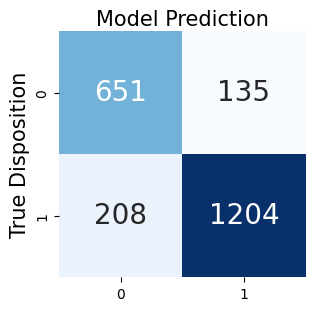

In [14]:
class_names=[0,0]
fig,ax=plt.subplots(figsize=(3,3))
tick_marks=(np.arange(len(class_names)))
plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)
sns.heatmap(pd.DataFrame(confusion_matrix(y_test,y_predict_1)),annot=True,
            cmap='Blues',fmt='g',cbar=False,
            annot_kws={'size':20})
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.ylabel('True Disposition', fontsize=15,y=0.5)
plt.xlabel('Model Prediction', fontsize=15)
plt.show()

Metrics

In [15]:
print(f'Precision: {precision_score(y_test,y_predict_1)}')
print(f'Accuracy: {accuracy_score(y_test,y_predict_1)}')
print(f'Recall: {recall_score(y_test,y_predict_1)}')

Precision: 0.8991784914115011
Accuracy: 0.8439490445859873
Recall: 0.8526912181303116


## Logistic Regression with Second Order Polinomial Fit

In [16]:
from sklearn.preprocessing import PolynomialFeatures

Preprocessing

In [17]:
poly_2=PolynomialFeatures(degree=2)
X_train_2=poly_2.fit_transform(X_train)
X_test_2=poly_2.transform(X_test)

Scaling

In [18]:
X_train_scaled_2=scaler.fit_transform(X_train_2)
X_test_scaled_2=scaler.fit_transform(X_test_2)

Logistic Regression

In [19]:
lr_2=LogisticRegression(max_iter=1000)
lr_2.fit(X_train_scaled_2,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


Crossed Validation

In [20]:
scores_2=cross_val_score(lr_2,X_train_scaled_2,y_train)
print(f'Logistic Regression Score = {scores_2.mean()} +/- {scores_2.std()}')

Logistic Regression Score = 0.8689305377264299 +/- 0.006545955091593531


In [21]:
y_predict_2=lr_2.predict(X_test_scaled_2)

Confusion Matrix

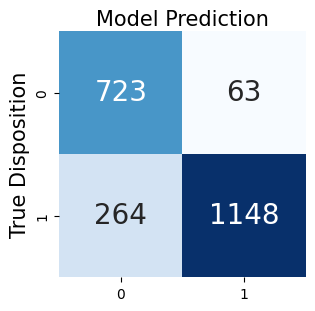

In [22]:
class_names=[0,0]
fig,ax=plt.subplots(figsize=(3,3))
tick_marks=(np.arange(len(class_names)))
plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)
sns.heatmap(pd.DataFrame(confusion_matrix(y_test,y_predict_2)),annot=True,
            cmap='Blues',fmt='g',cbar=False,
            annot_kws={'size':20})
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.ylabel('True Disposition', fontsize=15,y=0.5)
plt.xlabel('Model Prediction', fontsize=15)
plt.show()

Metrics

In [23]:
print(f'Precision: {precision_score(y_test,y_predict_2)}')
print(f'Accuracy: {accuracy_score(y_test,y_predict_2)}')
print(f'Recall: {recall_score(y_test,y_predict_2)}')

Precision: 0.9479768786127167
Accuracy: 0.8512283894449499
Recall: 0.8130311614730878


## Logistic Regression with Third Order Polinomial Fit

Preprocessing

In [24]:
poly_3=PolynomialFeatures(degree=3)
X_train_3=poly_3.fit_transform(X_train)
X_test_3=poly_3.transform(X_test)

Scaling

In [25]:
X_train_scaled_3=scaler.fit_transform(X_train_3)
X_test_scaled_3=scaler.fit_transform(X_test_3)

Logistic Regression

In [26]:
lr_3=LogisticRegression(max_iter=1000)
lr_3.fit(X_train_scaled_3,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


Crossed Validation

In [27]:
scores_3=cross_val_score(lr_3,X_train_scaled_3,y_train)
print(f'Logistic Regression Score = {scores_3.mean()} +/- {scores_3.std()}')

Logistic Regression Score = 0.8810239148005514 +/- 0.010603814313830959


In [28]:
y_predict_3=lr_3.predict(X_test_scaled_3)

Confusion Matrix

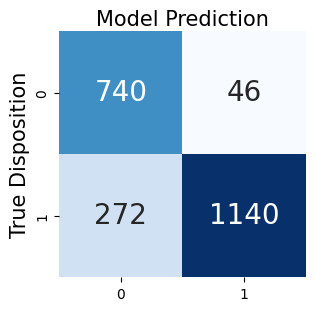

In [29]:
class_names=[0,0]
fig,ax=plt.subplots(figsize=(3,3))
tick_marks=(np.arange(len(class_names)))
plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)
sns.heatmap(pd.DataFrame(confusion_matrix(y_test,y_predict_3)),annot=True,
            cmap='Blues',fmt='g',cbar=False,
            annot_kws={'size':20})
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.ylabel('True Disposition', fontsize=15,y=0.5)
plt.xlabel('Model Prediction', fontsize=15)
plt.show()

Metrics

In [30]:
print(f'Precision: {precision_score(y_test,y_predict_3)}')
print(f'Accuracy: {accuracy_score(y_test,y_predict_3)}')
print(f'Recall: {recall_score(y_test,y_predict_3)}')

Precision: 0.9612141652613828
Accuracy: 0.8553230209281165
Recall: 0.8073654390934845


## Decision Tree

In [31]:
from sklearn.tree import DecisionTreeClassifier

In [32]:
dt=DecisionTreeClassifier()
dt.fit(X_train_scaled_1,y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


Crossed Validation

In [33]:
scores_dt=cross_val_score(dt,X_train_scaled_1,y_train)
print(f'Decision Tree Score = {scores_dt.mean()} +/- {scores_dt.std()}')

Decision Tree Score = 0.8716582513193553 +/- 0.007291083193232376


In [36]:
y_predict_dt=dt.predict(X_test_scaled_1)

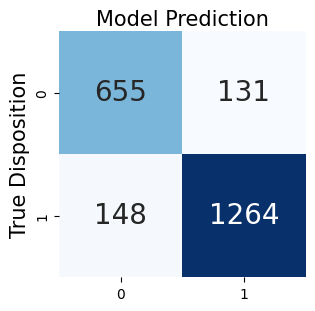

In [37]:
class_names=[0,0]
fig,ax=plt.subplots(figsize=(3,3))
tick_marks=(np.arange(len(class_names)))
plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)
sns.heatmap(pd.DataFrame(confusion_matrix(y_test,y_predict_dt)),annot=True,
            cmap='Blues',fmt='g',cbar=False,
            annot_kws={'size':20})
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.ylabel('True Disposition', fontsize=15,y=0.5)
plt.xlabel('Model Prediction', fontsize=15)
plt.show()

Metrics

In [38]:
print(f'Precision: {precision_score(y_test,y_predict_dt)}')
print(f'Accuracy: {accuracy_score(y_test,y_predict_dt)}')
print(f'Recall: {recall_score(y_test,y_predict_dt)}')

Precision: 0.9060931899641577
Accuracy: 0.873066424021838
Recall: 0.8951841359773371


## Random Forest

In [49]:
from sklearn.ensemble import RandomForestClassifier

In [50]:
rf=RandomForestClassifier(n_estimators=1000,random_state=10)
rf.fit(X_train_scaled_1,y_train)

,n_estimators,1000
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Crossed Validation

In [51]:
scores_rf=cross_val_score(rf,X_train_scaled_1,y_train)
print(f'Random Forest Score = {scores_rf.mean()} +/- {scores_rf.std()}')

Random Forest Score = 0.8754593009457488 +/- 0.011985559057259789


In [52]:
y_predict_rf=rf.predict(X_test_scaled_1)

Confusion Matrix

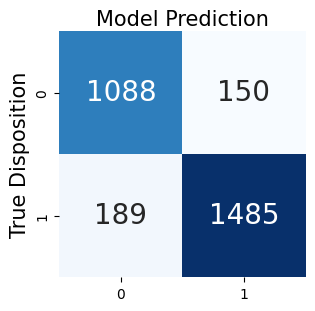

In [53]:
class_names=[0,0]
fig,ax=plt.subplots(figsize=(3,3))
tick_marks=(np.arange(len(class_names)))
plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)
sns.heatmap(pd.DataFrame(confusion_matrix(y_test,y_predict_rf)),annot=True,
            cmap='Blues',fmt='g',cbar=False,
            annot_kws={'size':20})
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.ylabel('True Disposition', fontsize=15,y=0.5)
plt.xlabel('Model Prediction', fontsize=15)
plt.show()

Metrics

In [54]:
print(f'Precision: {precision_score(y_test,y_predict_rf)}')
print(f'Accuracy: {accuracy_score(y_test,y_predict_rf)}')
print(f'Recall: {recall_score(y_test,y_predict_rf)}')

Precision: 0.908256880733945
Accuracy: 0.8835851648351648
Recall: 0.8870967741935484
